You are given a square maze of size 21×21, represented by a 2D grid of emojis:
  • Walls: ❤️ (impassable)
  • Free cells: 🙂 (traversable)

Coordinates are 0‑indexed: (0,0) is the top‑left, (20,20) is the bottom‑right.
Start position: (1, 0)
End position:   (19, 20)

Rules:
  1. You may move one cell at a time: up, down, left, or right.
  2. No diagonal moves.
  3. No skipping any cells.
  4. You cannot enter ❤️ cells or revisit any cell twice.

Output:
  • A single Python list of (row, col) tuples, in order from the start to the end, including both endpoints.
  • The entire list must appear on one line, with no extra text or commentary.

Example maze and correct solution (each line is one row):
❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️
🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂❤️🙂❤️🙂🙂🙂❤️
❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️🙂❤️🙂❤️🙂❤️🙂❤️❤️❤️
❤️🙂🙂🙂🙂🙂🙂🙂🙂🙂❤️🙂❤️🙂🙂🙂🙂🙂🙂🙂❤️
❤️🙂❤️❤️❤️❤️❤️🙂❤️❤️❤️🙂❤️❤️❤️❤️❤️🙂❤️❤️❤️
❤️🙂🙂🙂🙂🙂❤️🙂🙂🙂🙂🙂🙂🙂🙂🙂❤️🙂🙂🙂❤️
❤️🙂❤️🙂❤️❤️❤️🙂❤️🙂❤️❤️❤️🙂❤️❤️❤️🙂❤️🙂❤️
❤️🙂❤️🙂❤️🙂🙂🙂❤️🙂🙂🙂❤️🙂🙂🙂❤️🙂❤️🙂❤️
❤️🙂❤️❤️❤️❤️❤️❤️❤️❤️❤️🙂❤️🙂❤️❤️❤️❤

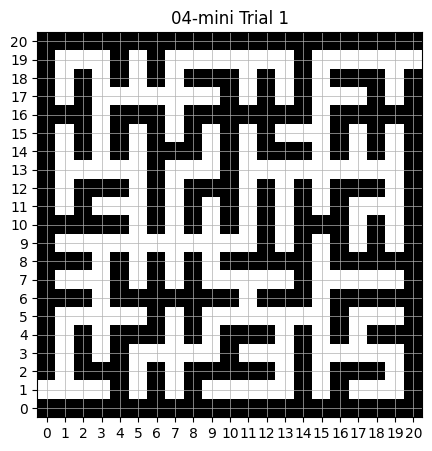

You are given a square maze of size 21×21, represented by a 2D grid of emojis:
  • Walls: ❤️ (impassable)
  • Free cells: 🙂 (traversable)

Coordinates are 0‑indexed: (0,0) is the top‑left, (20,20) is the bottom‑right.
Start position: (1, 0)
End position:   (19, 20)

Rules:
  1. You may move one cell at a time: up, down, left, or right.
  2. No diagonal moves.
  3. No skipping any cells.
  4. You cannot enter ❤️ cells or revisit any cell twice.

Output:
  • A single Python list of (row, col) tuples, in order from the start to the end, including both endpoints.
  • The entire list must appear on one line, with no extra text or commentary.

Example maze and correct solution (each line is one row):
❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️
🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂❤️🙂❤️🙂🙂🙂❤️
❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️🙂❤️🙂❤️🙂❤️🙂❤️❤️❤️
❤️🙂🙂🙂🙂🙂🙂🙂🙂🙂❤️🙂❤️🙂🙂🙂🙂🙂🙂🙂❤️
❤️🙂❤️❤️❤️❤️❤️🙂❤️❤️❤️🙂❤️❤️❤️❤️❤️🙂❤️❤️❤️
❤️🙂🙂🙂🙂🙂❤️🙂🙂🙂🙂🙂🙂🙂🙂🙂❤️🙂🙂🙂❤️
❤️🙂❤️🙂❤️❤️❤️🙂❤️🙂❤️❤️❤️🙂❤️❤️❤️🙂❤️🙂❤️
❤️🙂❤️🙂❤️🙂🙂🙂❤️🙂🙂🙂❤️🙂🙂🙂❤️🙂❤️🙂❤️
❤️🙂❤️❤️❤️❤️❤️❤️❤️❤️❤️🙂❤️🙂❤️❤️❤️❤

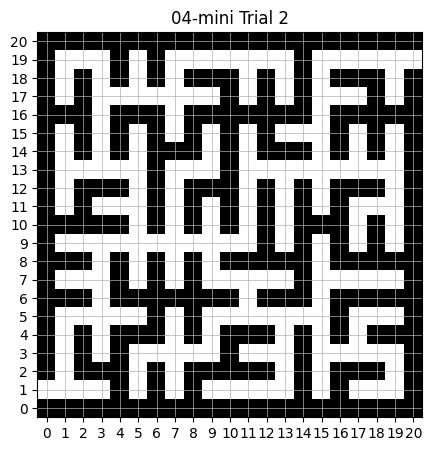

You are given a square maze of size 21×21, represented by a 2D grid of emojis:
  • Walls: ❤️ (impassable)
  • Free cells: 🙂 (traversable)

Coordinates are 0‑indexed: (0,0) is the top‑left, (20,20) is the bottom‑right.
Start position: (1, 0)
End position:   (19, 20)

Rules:
  1. You may move one cell at a time: up, down, left, or right.
  2. No diagonal moves.
  3. No skipping any cells.
  4. You cannot enter ❤️ cells or revisit any cell twice.

Output:
  • A single Python list of (row, col) tuples, in order from the start to the end, including both endpoints.
  • The entire list must appear on one line, with no extra text or commentary.

Example maze and correct solution (each line is one row):
❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️
🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂❤️🙂❤️🙂🙂🙂❤️
❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️🙂❤️🙂❤️🙂❤️🙂❤️❤️❤️
❤️🙂🙂🙂🙂🙂🙂🙂🙂🙂❤️🙂❤️🙂🙂🙂🙂🙂🙂🙂❤️
❤️🙂❤️❤️❤️❤️❤️🙂❤️❤️❤️🙂❤️❤️❤️❤️❤️🙂❤️❤️❤️
❤️🙂🙂🙂🙂🙂❤️🙂🙂🙂🙂🙂🙂🙂🙂🙂❤️🙂🙂🙂❤️
❤️🙂❤️🙂❤️❤️❤️🙂❤️🙂❤️❤️❤️🙂❤️❤️❤️🙂❤️🙂❤️
❤️🙂❤️🙂❤️🙂🙂🙂❤️🙂🙂🙂❤️🙂🙂🙂❤️🙂❤️🙂❤️
❤️🙂❤️❤️❤️❤️❤️❤️❤️❤️❤️🙂❤️🙂❤️❤️❤️❤

KeyboardInterrupt: 

In [30]:
import time
import json
import os
import re
import ast
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from openai import OpenAI
from typing import Callable, Dict, List, Tuple, Any
from mazes import Mazes

from dotenv import load_dotenv
load_dotenv()


class MazeSolverResult:
    def __init__(
        self,
        llm_name: str,
        maze_id: Tuple[int, int],
        path: List[Tuple[int, int]],
        valid: bool,
        solve_time: float,
        raw_response: str,
        source_file: str,
        history: List[Dict[str, Any]],
    ):
        self.llm_name = llm_name
        self.maze_id = maze_id
        self.path = path
        self.valid = valid
        self.solve_time = solve_time
        self.raw_response = raw_response
        self.source_file = source_file
        self.history = history

    def to_dict(self) -> Dict:
        return {
            "llm_name": self.llm_name,
            "grid_dim": self.maze_id[0],
            "maze_number": self.maze_id[1],
            "path": self.path,
            "valid": self.valid,
            "solve_time": self.solve_time,
            "raw_response": self.raw_response,
            "history": self.history,
            "source_file": self.source_file,
        }

    def __str__(self) -> str:
        status = "Success" if self.valid else "Failure"
        return f"[{self.llm_name}] {os.path.basename(self.source_file)} - {status} ({self.solve_time:.3f}s)"


class MazeTester:
    def __init__(
        self,
        llm_callables: Dict[str, Callable[[str], str]],
        maze_loader: Callable[[str], Mazes],
        max_trials: int = 5,
    ):
        self.llm_callables = llm_callables
        self.maze_loader = maze_loader
        self.max_trials = max_trials
        self.results: List[MazeSolverResult] = []

    def _format_base_prompt(self, maze: Mazes) -> str:
        dim = maze.grid.shape[0]
        start = (1, 0)
        end = (dim - 2, dim - 1)
        rows = [''.join('❤️' if cell else '🙂' for cell in row) for row in maze.grid]
        maze_str = "\n".join(rows)
        return (
            f"You are given a square maze of size {dim}×{dim}, represented by a 2D grid of emojis:\n"
            f"  • Walls: ❤️ (impassable)\n"
            f"  • Free cells: 🙂 (traversable)\n\n"
            f"Coordinates are 0‑indexed: (0,0) is the top‑left, ({dim-1},{dim-1}) is the bottom‑right.\n"
            f"Start position: {start}\n"
            f"End position:   {end}\n\n"
            f"Rules:\n"
            f"  1. You may move one cell at a time: up, down, left, or right.\n"
            f"  2. No diagonal moves.\n"
            f"  3. No skipping any cells.\n"
            f"  4. You cannot enter ❤️ cells or revisit any cell twice.\n\n"
            f"Output:\n"
            f"  • A single Python list of (row, col) tuples, in order from the start to the end, including both endpoints.\n"
            f"  • The entire list must appear on one line, with no extra text or commentary.\n\n"
            f"Example maze and correct solution (each line is one row):\n"
            "❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️\n"
            "🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂🙂❤️🙂❤️🙂🙂🙂❤️\n"
            "❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️🙂❤️🙂❤️🙂❤️🙂❤️❤️❤️\n"
            "❤️🙂🙂🙂🙂🙂🙂🙂🙂🙂❤️🙂❤️🙂🙂🙂🙂🙂🙂🙂❤️\n"
            "❤️🙂❤️❤️❤️❤️❤️🙂❤️❤️❤️🙂❤️❤️❤️❤️❤️🙂❤️❤️❤️\n"
            "❤️🙂🙂🙂🙂🙂❤️🙂🙂🙂🙂🙂🙂🙂🙂🙂❤️🙂🙂🙂❤️\n"
            "❤️🙂❤️🙂❤️❤️❤️🙂❤️🙂❤️❤️❤️🙂❤️❤️❤️🙂❤️🙂❤️\n"
            "❤️🙂❤️🙂❤️🙂🙂🙂❤️🙂🙂🙂❤️🙂🙂🙂❤️🙂❤️🙂❤️\n"
            "❤️🙂❤️❤️❤️❤️❤️❤️❤️❤️❤️🙂❤️🙂❤️❤️❤️❤️❤️❤️❤️\n"
            "❤️🙂🙂🙂❤️🙂🙂🙂🙂🙂🙂🙂❤️🙂❤️🙂🙂🙂❤️🙂❤️\n"
            "❤️🙂❤️❤️❤️❤️❤️❤️❤️🙂❤️❤️❤️🙂❤️❤️❤️🙂❤️🙂❤️\n"
            "❤️🙂❤️🙂❤️🙂🙂🙂🙂🙂❤️🙂🙂🙂🙂🙂🙂🙂🙂🙂❤️\n"
            "❤️🙂❤️🙂❤️❤️❤️❤️❤️❤️❤️🙂❤️❤️❤️🙂❤️❤️❤️🙂❤️\n"
            "❤️🙂❤️🙂❤️🙂🙂🙂❤️🙂🙂🙂❤️🙂❤️🙂🙂🙂❤️🙂❤️\n"
            "❤️❤️❤️🙂❤️❤️❤️🙂❤️❤️❤️🙂❤️🙂❤️🙂❤️❤️❤️🙂❤️\n"
            "❤️🙂🙂🙂🙂🙂❤️🙂🙂🙂🙂🙂❤️🙂🙂🙂🙂🙂❤️🙂❤️\n"
            "❤️❤️❤️🙂❤️🙂❤️🙂❤️❤️❤️🙂❤️🙂❤️🙂❤️❤️❤️🙂❤️\n"
            "❤️🙂❤️🙂❤️🙂❤️🙂❤️🙂🙂🙂❤️🙂❤️🙂❤️🙂❤️🙂❤️\n"
            "❤️🙂❤️❤️❤️🙂❤️🙂❤️❤️❤️🙂❤️🙂❤️❤️❤️🙂❤️🙂❤️\n"
            "❤️🙂🙂🙂🙂🙂🙂🙂🙂🙂❤️🙂❤️🙂🙂🙂🙂🙂❤️🙂🙂\n"
            "❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️\n"
            f"Correct solution: [(1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (2, 11), (3, 11), (4, 11), (5, 11), (5, 12), (5, 13) (6, 13), (7, 13), (8, 13), (9, 13), (10, 13), (11, 13), (11, 14), (11, 15), (11, 16), (11, 17), (11, 18), (11, 19), (12, 19), (13, 19), (14, 19), (15, 19), (16, 19), (17, 19), (18, 19), (19, 19), (19, 20)]\n\n"
            f"Here is the maze map you need to solve (each line is one row). Please find the SHORTEST valid path:\n"
            f"{maze_str}"
            )

    def _parse_response(self, response: str) -> List[Tuple[int, int]]:
        list_pat = r"\[(?:\s*\(\d+,\s*\d+\s*\)(?:,\s*\(\d+,\s*\d+\s*\))*)\]"
        match = re.search(list_pat, response)
        if match:
            coords = re.findall(r"\((\d+),\s*(\d+)\)", match.group(0))
            return [(int(r), int(c)) for r, c in coords]
        for line in response.splitlines():
            if '[' in line and ']' in line:
                try:
                    cand = ast.literal_eval(line[line.find('['):line.rfind(']')+1])
                    if isinstance(cand, list) and all(isinstance(p, tuple) for p in cand):
                        return cand
                except:
                    pass
        return []

    def _validate_first(self, maze: Mazes, path: List[Tuple[int, int]]) -> Tuple[bool, List[int]]:
        # Returns validity and list containing only the first invalid index
        dim = maze.grid.shape[0]
        start = (1, 0)
        end = (dim - 2, dim - 1)
        invalid = []
        if not path or path[0] != start:
            return False, [0]
        for idx, (prev, curr) in enumerate(zip(path, path[1:]), start=1):
            r1, c1 = prev; r2, c2 = curr
            if not (0 <= r2 < dim and 0 <= c2 < dim) or maze.grid[r2, c2] == 1 or abs(r1-r2)+abs(c1-c2) != 1:
                return False, [idx]
        if path[-1] != end:
            return False, [len(path)-1]
        return True, []

    def _validate_all(self, maze: Mazes, path: List[Tuple[int, int]]) -> List[int]:
        # Returns all invalid indices without breaking
        dim = maze.grid.shape[0]
        start = (1, 0)
        end = (dim - 2, dim - 1)
        invalid = []
        if not path or path[0] != start:
            invalid.append(0)
        for idx, (prev, curr) in enumerate(zip(path, path[1:]), start=1):
            r1, c1 = prev; r2, c2 = curr
            if not (0 <= r2 < dim and 0 <= c2 < dim) or maze.grid[r2, c2] == 1 or abs(r1-r2)+abs(c1-c2) != 1:
                invalid.append(idx)
        if path and path[-1] != end:
            invalid.append(len(path)-1)
        return invalid

    def _plot(self, maze: Mazes, path: List[Tuple[int,int]], invalid_all: List[int], name: str, t: int):
        dim = maze.grid.shape[0]
        fig, ax = plt.subplots(figsize=(5,5))
        ax.imshow(maze.grid, cmap=colors.ListedColormap(['white','black']), origin='upper')
        ax.set_title(f"{name} Trial {t}")
        ax.set_xticks(range(dim)); ax.set_yticks(range(dim)); ax.grid(True, linewidth=0.5)
        for i, (r, c) in enumerate(path):
            col = 'red' if i in invalid_all else 'green'
            ax.scatter(c, r, c=col, s=80, marker='s', edgecolors='none')
            ax.text(c, r, str(i), va='center', ha='center', color='white', fontsize=7)
        ax.invert_yaxis()
        plt.show()

    def solve_maze(self, filename: str):
        maze = self.maze_loader(filename)
        dim = maze.grid.shape[0]
        start = (1, 0)
        end = (dim - 2, dim - 1)
        base = self._format_base_prompt(maze)
        for name, fn in self.llm_callables.items():
            history = []
            final = []
            valid = False
            start_time = time.time()
            for trial in range(1, self.max_trials+1):
                prompt = base
                for i, h in enumerate(history, 1):
                    _, first_invalid = self._validate_first(maze, h['path'])
                    all_invalid = self._validate_all(maze, h['path'])
                    fb = first_invalid[0]
                    prompt += f"\n\nHere's a previous attempt including all steps you took marked as Valid or Invalid. Note that a valid step doesn not mean it is part of the solution. An invalid step means you entered a wall, jumped a cell, or walked diagonally.:\n"
                    prompt += f"Attempt {i}:\n"
                    # Create a list of steps with their validity status
                    path_with_status = []
                    for j, step in enumerate(h['path']):
                        status = "Invalid" if j in all_invalid else "Valid"
                        path_with_status.append(f"{step}: {status}")
                    prompt += f"{path_with_status}\n"
                print(prompt)
                resp = fn(prompt)
                print(resp)
                path = self._parse_response(resp)
                ok, first_inv = self._validate_first(maze, path)
                all_inv = self._validate_all(maze, path)
                history.append({'path': path, 'invalid_first': first_inv, 'invalid_all': all_inv})
                self._plot(maze, path, all_inv, name, trial)
                if ok:
                    final = path; valid = True; break
            self.results.append(
                MazeSolverResult(name, (dim, maze.maze_number), final, valid,
                                 time.time() - start_time, str(final), filename, history)
            )

    def test_many(self, files: List[str]) -> List[MazeSolverResult]:
        for f in files:
            self.solve_maze(f)
        return self.results

    def save_results(self, out_file: str) -> None:
        with open(out_file, 'w') as f:
            json.dump([r.to_dict() for r in self.results], f, indent=2)

    def summary(self) -> Dict[str, Dict[str, float]]:
        stats: Dict[str, Dict[str, float]] = {}
        for r in self.results:
            m = stats.setdefault(r.llm_name, {"total":0, "successes":0, "time":0.0})
            m['total'] += 1
            m['successes'] += int(r.valid)
            m['time'] += r.solve_time
        for s in stats.values():
            s['avg_time'] = s['time'] / s['total']
            s['success_rate'] = s['successes'] / s['total']
        return stats

    def display_solutions(self) -> None:
        for res in self.results:
            print(str(res))


if __name__ == "__main__":

    def make_openai_callable(model: str) -> Callable[[str], str]:
        client = OpenAI(
            api_key=os.getenv("OPENAI_API_KEY")
        )
        return lambda prompt: client.responses.create(
            model=model,
            instructions="You are an expert maze solver.",
            input=prompt,
            #temperature=0,
        ).output_text

    llm_map = {
        "04-mini": make_openai_callable("o4-mini"),

    }

    tester = MazeTester(llm_map, Mazes.load)
    files = ["mazes/maze_10x10_6.json",]
    tester.test_many(files)
    tester.save_results("llm_maze_results.json")

    print("All solutions (text):")
    tester.display_solutions()

    print("Summary:")
    for model, stats in tester.summary().items():
        print(f"- {model}: {stats['successes']}/{stats['total']} solved "
              f"({stats['success_rate']:.0%}), avg {stats['avg_time']:.3f}s")
